In [27]:
import wikipedia as wp
page = "2016_Summer_Olympics_medal_table"
#print wp.summary(page, sentences=1)
mp = wp.WikipediaPage(page)
#print mp.title
#print mp.url
#print mp.content
#print mp.html()
#dir(mp.html)

[[1, 2], [2, 5]]


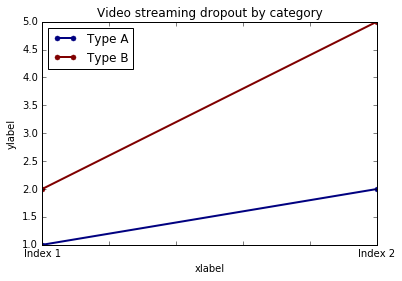

In [38]:
import matplotlib.pyplot as plt 
import pandas as pd

plt.figure()
values = [[1,2], [2,5]]
print values
df2 = pd.DataFrame(values, columns=['Type A', 'Type B'], index=['Index 1','Index 2'])
df2.plot(lw=2,colormap='jet',marker='.',markersize=10,title='Video streaming dropout by category')
plt.xlabel('xlabel')
plt.ylabel('ylabel')
plt.show()

In [54]:
df = pd.DataFrame([[1, 2, 3], [4, 5 ,6]], columns=list('ABC'))
df
df = df.set_index('A')
df


,B,C
A,,
1,2,3
4,5,6


In [97]:
import os
import os.path
import urllib2

from bs4 import BeautifulSoup

import numpy as np

from pandas import Series, DataFrame
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import pdb

def getText(cell):
    #due to data observed like <num><superscript> or 65[1]
    t = cell.text.strip().split(" ")[0]
    return t.strip().split("[")[0]

def populateDataFrame(year):
    dataDir = "olympics_medal_data"
    if not os.path.exists(dataDir):
        os.makedirs(dataDir)
    filePath = os.path.join(os.getcwd(), dataDir, "%s-medals.csv" % year)
    if not os.path.exists(filePath):
        wiki = "https://en.wikipedia.org/wiki/%s_Summer_Olympics_medal_table" % year
        header = {'User-Agent': 'Mozilla/5.0'} #Needed to prevent 403 error on Wikipedia
        req = urllib2.Request(wiki,headers=header)
        try:
            page = urllib2.urlopen(req)
	except urllib2.HTTPError, e:
	    print "URL not available for year %s" % year
	    return
	except urllib2.URLError, e:
	    print (e, e.args)
	    return
        soup = BeautifulSoup(page, "lxml") 
        table = soup.findAll("table", { "class" : [ "wikitable sortable plainrowheaders", 
                                                    "wikitable"]})
        if not table:
            print "Could not find table for year %s" % year
            return
        #1928 has 2 tables
        table = table[0]
        rank = 0
        country = None
        gold = 0
        silver = 0
        bronz = 0
        total = 0
        prevRank = 0

        data = []
        for row in table.findAll("tr")[1:-1]:
            try:
                ths = row.findAll("th")
                if ths:
                    country = row.findAll("th")[0].img['title']

                tds = row.findAll("td")
                if len(tds) == 6:
                    rank = getText(tds[0])
                    if hasattr(tds[1], 'img'):
                        country = tds[1].img['title']
                    gold = getText(tds[2])
                    silver = getText(tds[3])
                    bronz = getText(tds[4])
                    total = getText(tds[5])
                elif len(tds) == 5:
                    #mostly older pages have 5 tds and country in tds
                    #1900 has mexico and sweden rank applicable to 2 rows
                    prevRank = rank
                    try:
                        rank = getText(tds[0])
                    except Exception, e:
                        print e
                        #use previous row's rank
                    if not rank.isnumeric():
                        country = rank
                        rank = prevRank
                    else:
                        if not country:
                            country = rank #getText(tds[0])
                    gold = getText(tds[1])
		    silver = getText(tds[2])
		    bronz = getText(tds[3])
		    total = getText(tds[4])
                elif len(tds) == 4:
                    gold = getText(tds[0])
                    silver = getText(tds[1])
                    bronz = getText(tds[2])
                    total = getText(tds[3])
                else:
                    raise Exception("Invalid Data")

            except IndexError, e:
                print e

            col = (year, rank, country, gold, silver, bronz, total)
            data.append(col)

        df = pd.DataFrame(data, columns=['year', 'rank', 'country', 'gold', 'silver', 'bronz', 'total'])
        df.to_csv(filePath, header=True, index=False, encoding='utf-8')
    else:
        df = pd.read_csv(filePath)

    # Normalize data types
    df[['rank', 'gold', 'silver', 'bronz', 'total']] = df[['rank', 'gold', 'silver', 'bronz', 'total']].astype(int)

    df = df.set_index(['year', 'country'])
    return df

def plotDataFrames(df):
    #fig, axes = plt.subplots(nrows=4, ncols=1)
    #for i, c in enumerate(df.columns[1:]):
    #    df[c].plot(kind='bar', ax=axes[i], figsize=(12, 10), title=c)
    #plt.savefig('EU1.png', bbox_inches='tight')

    return

    #https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
    # Create a figure of given size
    fig = plt.figure(figsize=(16,12))
    # Add a subplot
    ax = fig.add_subplot(111)
    # Set title
    ttl = 'Olympics medals by Country and then in future by year'

    ax.set_xlabel("Gold Medals")
    ax.set_ylabel("Countries")

    # Set color transparency (0: transparent; 1: solid)
    a = 0.7
    # Create a colormap
    customcmap = [(x/90.0,  x/130.0, 0.05) for x in range(len(df))]
    # Plot the 'population' column as horizontal bar plot
    df['gold'].plot(kind='barh', ax=ax, alpha=a, legend=False, color=customcmap,
                        edgecolor='w', xlim=(0,max(df['gold'])), title=ttl)


if __name__ == "__main__":
    #pdb.set_trace()
    #print populateDataFrame(2008)
    #import sys; sys.exit(0)

    #https://en.wikipedia.org/wiki/Olympic_medal_table
    modernOlympicsStartYear=1896
    dff = None
    for year in xrange(modernOlympicsStartYear, 2020, 4):
        df = populateDataFrame(year)
        if df is None:
            continue
        print df
        if dff is None:
            dff = df
        else:
            dff = dff.append(df)

    if dff is None:
        exit(1)

    #plotDataFrames(dff)


                    rank  gold  silver  bronz  total
year country                                        
1896 United States     1    11       7      2     20
     Greece            2    10      17     19     46
     Germany           3     6       5      2     13
     France            4     5       4      2     11
     Great Britain     5     2       3      2      7
     Hungary           6     2       1      3      6
     Austria           7     2       1      2      5
     Australia         8     2       0      0      2
     Denmark           9     1       2      3      6
     Switzerland      10     1       2      0      3
     Mixed team       11     1       1      1      3
                    rank  gold  silver  bronz  total
year country                                        
1900 France            1    26      41     34    101
     United States     2    19      14     14     47
     Great Britain     3    15       6      9     30
     Mixed team        4     6       3      3 

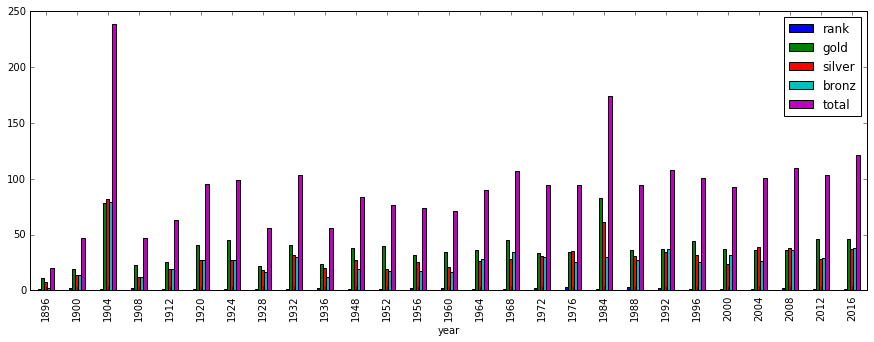

In [197]:
#dff.index.names
#dff.index.get_level_values('country')
#repr(dff.index)
#dff.loc[2012:]
#dff.xs((2016, 'United States'), level=('year', 'country'))
#dff.xs((2016, 'India'), level=('year', 'country'))
dfUSAByYears = dff.xs('United States', level='country')
#plt.scatter(dfUSAByYears.index.values, dfUSAByYears.gold)
#plt.plot(dfUSAByYears.gold)
import matplotlib
width = 15
height = 5
matplotlib.rcParams['figure.figsize'] = (width, height)
dfUSAByYears.plot(kind='bar')